<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

# O cenário da cidade do Rio de Janeiro: Distribuição inicial de Infectados

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
import episiming

## Criando o cenário do Rio com redução

In [3]:
tx_reducao = 100
landscan_file = '../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy'
piramide_file = 'piramide_etaria_MRJ.csv'
escolas_file = 'municipais.npy'
cenario_rio = episiming.cenarios.RiodeJaneiro(tx_reducao, landscan_file, piramide_file, escolas_file)
print(f'População do cenário reduzido: {cenario_rio.num_pop}\n')

População do cenário reduzido: 67973



### População do Rio de Janeiro

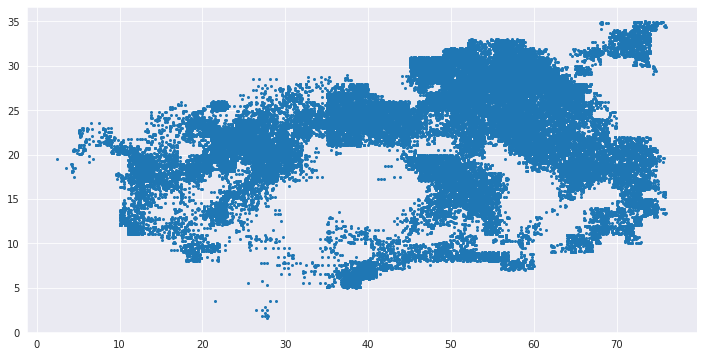

In [4]:
x, y = cenario_rio.pop_posicoes.T
plt.figure(figsize=(12,6))
plt.scatter(x, y, s=4)
plt.show()

### Carregando matriz com a relação dos bairros nos blocos

In [5]:
mtrx_bairros = np.load('geoloc_Bairros_MRJ.npy')

### Carregando matriz com infectados por blocos. Dados de 15/06/2020

In [6]:
mtrx_infectados = np.load('infectados.npy')

## Tratamento da subnotificação

In [7]:
def corrige_subnotificacao(mtrx_infectaos):
    return mtrx_infectados*8

## Redução dos casos de infectados de acordo com `tx_reducao`

In [8]:
def reducao_mtrx(tx_reducao, mtrx):
    if tx_reducao == 1:
        mtrx_reduzida = mtrx
    else:
        qt_total = np.rint(np.sum(mtrx)/tx_reducao)
        rng_blocos = np.arange(np.prod(np.shape(mtrx)))
        pesos = (mtrx/np.sum(mtrx)).flatten()
        escolha = np.array(random.choices(rng_blocos, pesos, k = int(qt_total)))

        rows = np.floor(escolha/83)
        cols = np.mod(escolha,83)
        mtrx_reduzida = np.zeros((39,83))
        for i,j in zip(rows,cols):
            mtrx_reduzida[int(i)][j] += 1
    return mtrx_reduzida

As posições da população são dadas com o eixo `y` em ordem diferente das matrizes de blocos, aqui fazemos uma troca de linhas 

In [9]:
def corrige_mtrx(mtrx):
        new_mtrx = np.zeros(np.shape(mtrx))
        for i in range(39):
            new_mtrx[np.abs(i-38)] = mtrx[i]
        return new_mtrx

## Distribue os casos nos blocos

O output desta função é uma lista com o indíce dos indivíduos que terão `estado = 2`, ou seja, infectados

Como input temos:

- `tx_reducao`: Taxa de redução do cenário
- `mtrx_casos`: Matriz com os casos de infectados por bloco
- `pop_posicoes`: Posição da população, quando implementado em `episiming` este parametro some e é usado `self.pop_posicoes`


In [111]:
def distribuicao_inicial_casos(tx_reducao, mtrx_casos, pop_posicoes):
    mtrx_casos = corrige_mtrx(mtrx_casos)

    pos_indv_blocos = np.round(pop_posicoes)
    mtrx_casos_reduzida = reducao_mtrx(tx_reducao, mtrx_casos)

    casos = []
    rng = np.arange(len(pos_indv_blocos))
    for x in range(83):
        for y in range(39):
            checa_bloco_indv = pos_indv_blocos == [x,y]
            indv_nos_blocos =  np.logical_and(checa_bloco_indv[:,0], checa_bloco_indv[:,1])
            indices_no_bloco = rng[indv_nos_blocos]
            qt_bloco = mtrx_casos_reduzida[y,x]                  
            if (qt_bloco > 0) & (len(indices_no_bloco) > 0):
                indv_casos = np.random.choice(indices_no_bloco, int(qt_bloco))
                for e in indv_casos:
                    casos.append(e)
    return casos

### Chamando a função

In [107]:
mtrx_infectados_real = corrige_subnotificacao(mtrx_infectados)

In [112]:
# %%timeit
infectados_0 = distribuicao_inicial_casos(tx_reducao, mtrx_infectados_real, cenario_rio.pop_posicoes)

In [113]:
total_infectados = np.sum(mtrx_infectados_real)

In [114]:
print(f'Total de Infectados dada a redução: {np.rint(total_infectados/tx_reducao)}, Casos distribuidos: {len(infectados_0)}')

Total de Infectados dada a redução: 122.0, Casos distribuidos: 115


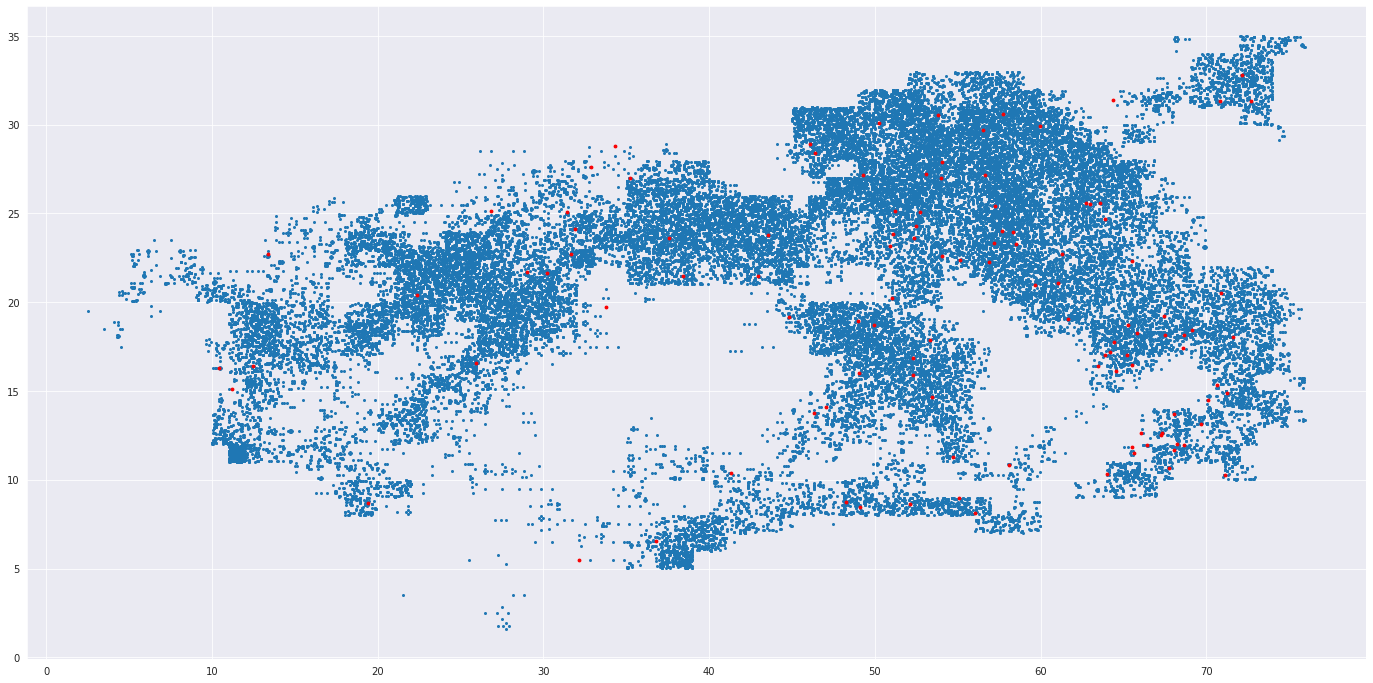

In [48]:
x, y = cenario_rio.pop_posicoes.T
x_inf, y_inf = cenario_rio.pop_posicoes[infectados_0].T
plt.figure(figsize=(24,12))
plt.scatter(x, y, s=4)
plt.scatter(x_inf, y_inf, s=8, color = 'red')
plt.show()

## Plot da posição da população com o mapa do Rio de Janeiro

In [95]:
mtrx_bairros

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 13.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [16]:
mtrx_bairros_plot = corrige_mtrx(mtrx_bairros)

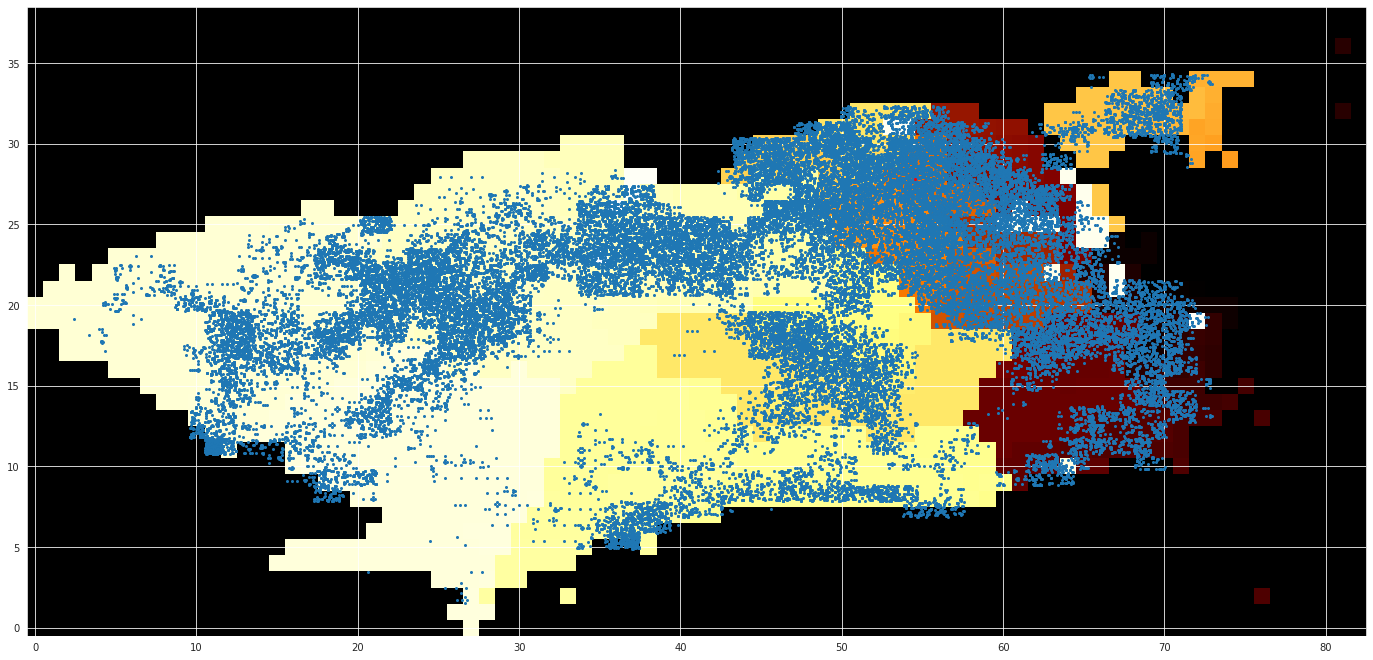

In [105]:
x, y = cenario_rio.pop_posicoes.T
plt.figure(figsize=(24,12))
plt.scatter(x*0.96, y*0.98, s=4)
plt.scatter(cenario_rio.pop_posicoes[12643][0], cenario_rio.pop_posicoes[12643][1], color = 'red', s= 4)
plt.imshow(mtrx_bairros_plot, cmap = 'afmhot')
plt.gca().invert_yaxis()
plt.show()

In [98]:
cenario_rio.pop_posicoes*0.8

array([[54.53333333, 27.33333333],
       [55.15555556, 27.86666667],
       [54.97777778, 27.86666667],
       ...,
       [22.2       ,  1.53333333],
       [22.06666667,  1.4       ],
       [22.2       ,  1.26666667]])

# Alguns testes

Vamos fazer a distribuição dos casos diagnosticados e comparar com a tabela da prefeitura

In [78]:
def set_df(fonte, **kwargs):
    """Carrega o CSV com dados do covid para determinada cidade ou estado e retorna um pandas.DataFrame com os dados

    Parameters
    ----------
    fonte : str ('prefeitura_rj', 'estado_rj')
        Indica qual a fonte dos dados, com isso a função determina qual CSV carregar e como tratar o DataFrame.
        O arquivo a ser carregado é dado em configs.yml
    *args : dict, optional
        Um dicionário com argumentos extras:
            df_break: Se setado para True, muda o retorno para vários DataFrames
    Returns
    -------
    ret_v: Se nenhum argumento opcional for passado, ret_v é uma lista contendo o DataFrame tratado com todos os casos, e a data de atualização dos dados
            df_break == True: ret_v é uma lista com [DataFrame Tratado, [DataFrame Ativos, DataFrame Recuperados, DataFrame Obitos], Data de Atualização]        
    """

    if fonte == 'prefeitura_rj':
        df = pd.read_csv('Dados_indiv_MRJ_covid_19.csv', encoding = 'iso-8859-1', delimiter = ';')
        df.rename(columns = configs['df']['rename']['rj']['colunas']['prefeitura'], inplace = True)
        dt_att = df['Data_atualização'].values[0]
        for drop in configs['df']['droppable']['rj']['prefeitura']:
            df.drop(drop, axis = 1, inplace = True)
        for r in configs['df']['rename']['rj']['dados']['prefeitura']:
            df[r].replace(configs['df']['rename']['rj']['dados']['prefeitura'][r], inplace = True)
        if 'df_break' in kwargs  and kwargs['df_break'] == True:
            df_break = []
            for s in configs['df']['status']['rj']['prefeitura']:
                df_break.append(df[df['Evolucao'] == s])
            ret_lst = [df, df_break, dt_att]
        else:
            ret_lst = [df, dt_att]
    elif fonte == 'estado_rj':
        df = pd.read_csv(root_dir + '/' + configs['csv']['rj']['file_loc']['estado'])
        df = df[df['classificacao'] == 'CONFIRMADO']
        df.rename(columns = configs['df']['rename']['rj']['colunas']['estado'], inplace = True)
        for drop in configs['df']['droppable']['rj']['estado']:
            df.drop(drop, axis = 1, inplace = True)
        for r in configs['df']['rename']['rj']['dados']['estado']:
            df[r].replace(configs['df']['rename']['rj']['dados']['estado'][r], inplace = True)
        df['Municipio'] = [m.title()  for m in df['Municipio']]
        if args and args[0]['df_break'] == True:
            df_break = []
            for s in configs['df']['status']['rj']['estado']:
                df_break.append(df[df['Evolucao'] == s])
            ret_lst = [df, df_break]
        else:
            ret_lst = df
    else: 
        print('Fonte de dados Inválida, as opções são prefeitura_rj ou estado_rj')
        ret_lst = 'Error'
    return ret_lst

In [79]:
import yaml

In [80]:
with open('config.yml', encoding = 'utf-8') as f:
    configs = yaml.load(f, Loader = yaml.FullLoader)
    
with open('bairros.yml', encoding = 'utf-8') as f:
    ids = yaml.load(f, Loader = yaml.FullLoader)

In [81]:
df = set_df('prefeitura_rj', df_break = True)

In [82]:
def conta_infectados_bairros(infectados, mtrx_bairros):
    pos_blocos_infectados = np.round(cenario_rio.pop_posicoes[infectados])
    ids_bairros = [mtrx_bairros[int(i[1]),int(i[0])] for i in pos_blocos_infectados]
    bairros_count = {}
    for i in set(ids_bairros):
        bairros_count.update({int(i): ids_bairros.count(i)})
    return bairros_count

In [83]:
df_atv = df[1][0]

In [84]:
diagnosticados = distribuicao_inicial_casos(1, mtrx_infectados, cenario_rio.pop_posicoes)

In [85]:
def count_estado_bairro(df,ids, infectados, mtrx_bairros):
    n = [0]
    infect_por_bairro = conta_infectados_bairros(infectados, mtrx_bairros)
    for i in range(1,164):
        if i in infect_por_bairro.keys():
            n.append([len(df[df['Bairro'] == ids[i]]), infect_por_bairro[i]])
        else:
            n.append([len(df[df['Bairro'] == ids[i]]), 0])
    dic = {ids[i]: n[i] for i in range(1,164)}
    indef = len(df[df['Bairro'] == 'INDEFINIDO'])
    return dic, indef

In [86]:
dic_infectados, n_indef = count_estado_bairro(df_atv, ids['id_bairros'], diagnosticados, mtrx_bairros_plot)

In [87]:
dic_infectados

{'SAUDE': [2, 2],
 'GAMBOA': [4, 4],
 'SANTO CRISTO': [0, 0],
 'CAJU': [1, 1],
 'CENTRO': [10, 10],
 'CATUMBI': [7, 7],
 'RIO COMPRIDO': [8, 8],
 'CIDADE NOVA': [0, 0],
 'ESTACIO': [8, 8],
 'SAO CRISTOVAO': [10, 10],
 'MANGUEIRA': [3, 3],
 'BENFICA': [7, 7],
 'PAQUETA': [0, 0],
 'SANTA TERESA': [4, 1],
 'FLAMENGO': [28, 28],
 'GLORIA': [3, 4],
 'LARANJEIRAS': [16, 16],
 'CATETE': [12, 12],
 'COSME VELHO': [4, 5],
 'BOTAFOGO': [30, 30],
 'HUMAITA': [3, 3],
 'URCA': [7, 7],
 'LEME': [1, 1],
 'COPACABANA': [58, 58],
 'IPANEMA': [20, 15],
 'LEBLON': [20, 20],
 'LAGOA': [10, 10],
 'JARDIM BOTANICO': [5, 5],
 'GAVEA': [53, 53],
 'VIDIGAL': [2, 2],
 'SAO CONRADO': [11, 6],
 'PRACA DA BANDEIRA': [6, 6],
 'TIJUCA': [60, 56],
 'ALTO DA BOA VISTA': [3, 4],
 'MARACANA': [11, 11],
 'VILA ISABEL': [13, 13],
 'ANDARAI': [10, 10],
 'GRAJAU': [11, 7],
 'MANGUINHOS': [4, 4],
 'BONSUCESSO': [17, 17],
 'RAMOS': [14, 14],
 'OLARIA': [10, 11],
 'PENHA': [10, 10],
 'PENHA CIRCULAR': [10, 10],
 'BRAS DE PINA'

In [88]:
diagn_df = np.array(list(dic_infectados.values()))[:,0]
diagn_mtrx = np.array(list(dic_infectados.values()))[:,1]

In [89]:
diagn_df, diagn_mtrx

(array([ 2,  4,  0,  1, 10,  7,  8,  0,  8, 10,  3,  7,  0,  4, 28,  3, 16,
        12,  4, 30,  3,  7,  1, 58, 20, 20, 10,  5, 53,  2, 11,  6, 60,  3,
        11, 13, 10, 11,  4, 17, 14, 10, 10, 10, 13,  1,  3,  6,  3,  6,  1,
         3,  5,  6,  6,  5,  3,  4,  1,  0,  5,  4, 19, 10, 11,  5,  1,  2,
        14,  4, 10,  2,  4, 10,  0, 18,  3,  6,  5,  1,  0,  3, 10,  1,  3,
        12,  1, 11,  8,  6,  0,  0,  1,  0,  2,  1,  3,  3,  9,  1,  2,  2,
         7,  7,  1, 12, 11,  3,  7,  8,  2,  3,  2,  8, 34, 13,  7,  2,  7,
        16, 13, 25,  5,  7, 15,  0,  7, 77,  3,  1,  3, 37,  0,  1,  1,  0,
         5,  6, 36,  8, 34,  9, 11, 53,  7,  6, 15, 16, 34, 10, 11,  0,  2,
        14,  0,  0,  1,  0,  2,  0,  0,  0,  0]),
 array([ 2,  4,  0,  1, 10,  7,  8,  0,  8, 10,  3,  7,  0,  1, 28,  4, 16,
        12,  5, 30,  3,  7,  1, 58, 15, 20, 10,  5, 53,  2,  6,  6, 56,  4,
        11, 13, 10,  7,  4, 17, 14, 11, 10, 10, 13,  2,  3,  6,  3,  6,  1,
         3,  5,  6,  8,  5,  3,  6,  1

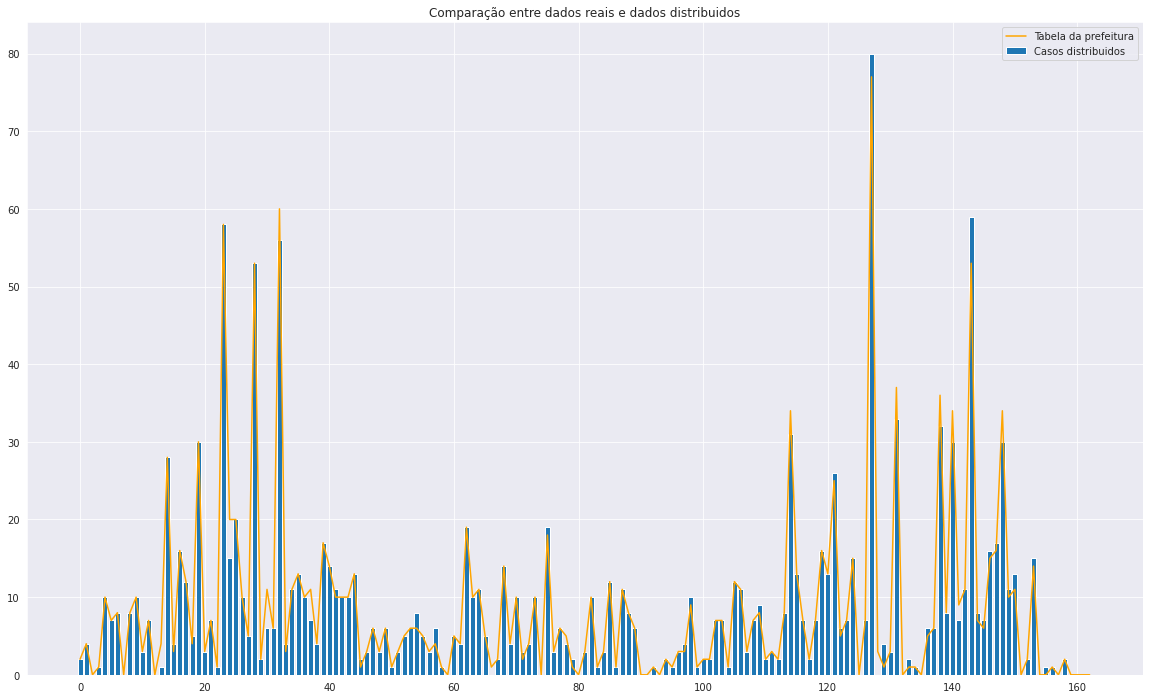

In [92]:
plt.figure(figsize = (20,12))

plt.bar(range(len(dic_infectados)), diagn_mtrx, align='center', label = 'Casos distribuidos')
plt.plot(diagn_df, color = 'orange', label = 'Tabela da prefeitura')
#plt.xticks(range(len(dic_infectados)), list(dic_infectados.keys()))
plt.legend()
plt.title('Comparação entre dados reais e dados distribuidos')
plt.show()

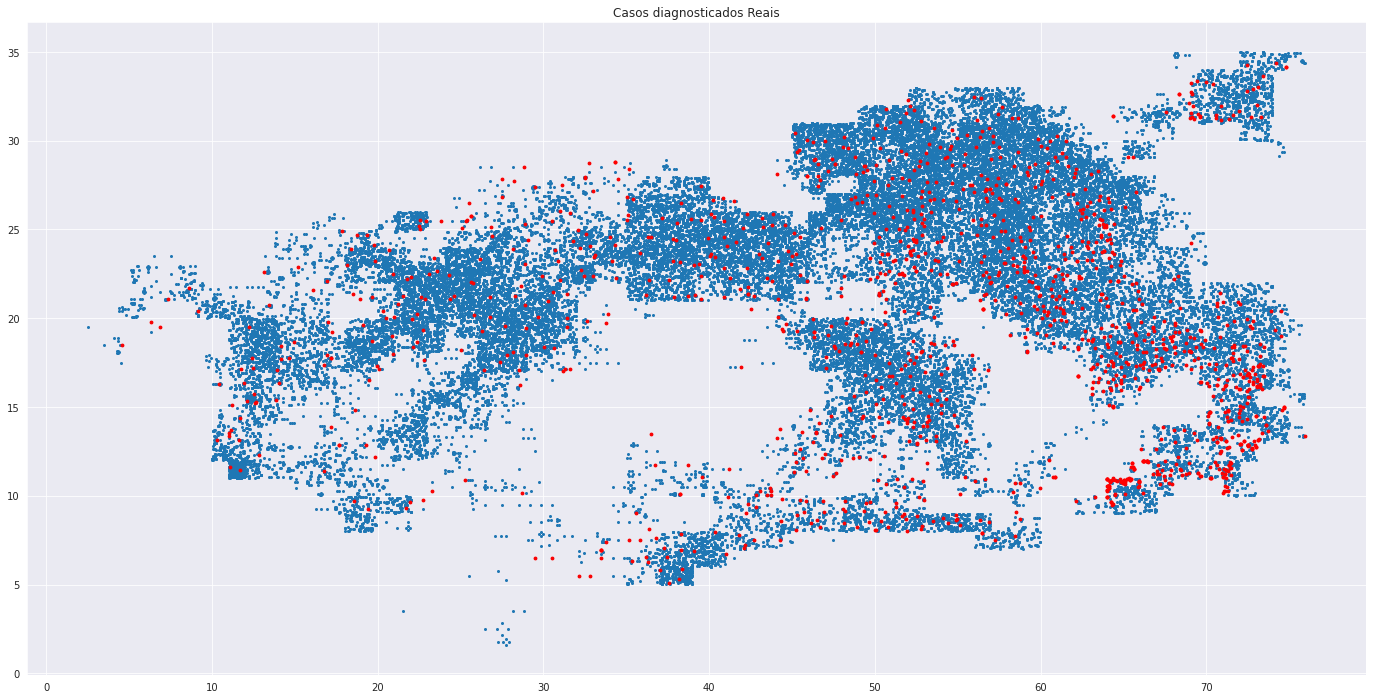

In [50]:
x, y = cenario_rio.pop_posicoes.T
x_inf, y_inf = cenario_rio.pop_posicoes[diagnosticados].T
plt.figure(figsize=(24,12))
plt.scatter(x, y, s=4)
plt.scatter(x_inf, y_inf, s=8, color = 'red')
plt.title('Casos diagnosticados Reais')
plt.show()

# Inicializando Infecção em 16/05

In [60]:
mtrx_infect_1605 = np.load('infectados_1605.npy')

In [61]:
mtrx_infect_1605_real = corrige_subnotificacao(mtrx_infect_1605)

In [62]:
infectados_1605_0 = distribuicao_inicial_casos(tx_reducao, mtrx_infect_1605_real, cenario_rio.pop_posicoes)

In [68]:
len(infectados_1605_0), np.rint(np.sum(mtrx_infect_1605_real)/tx_reducao)

(111, 122.0)

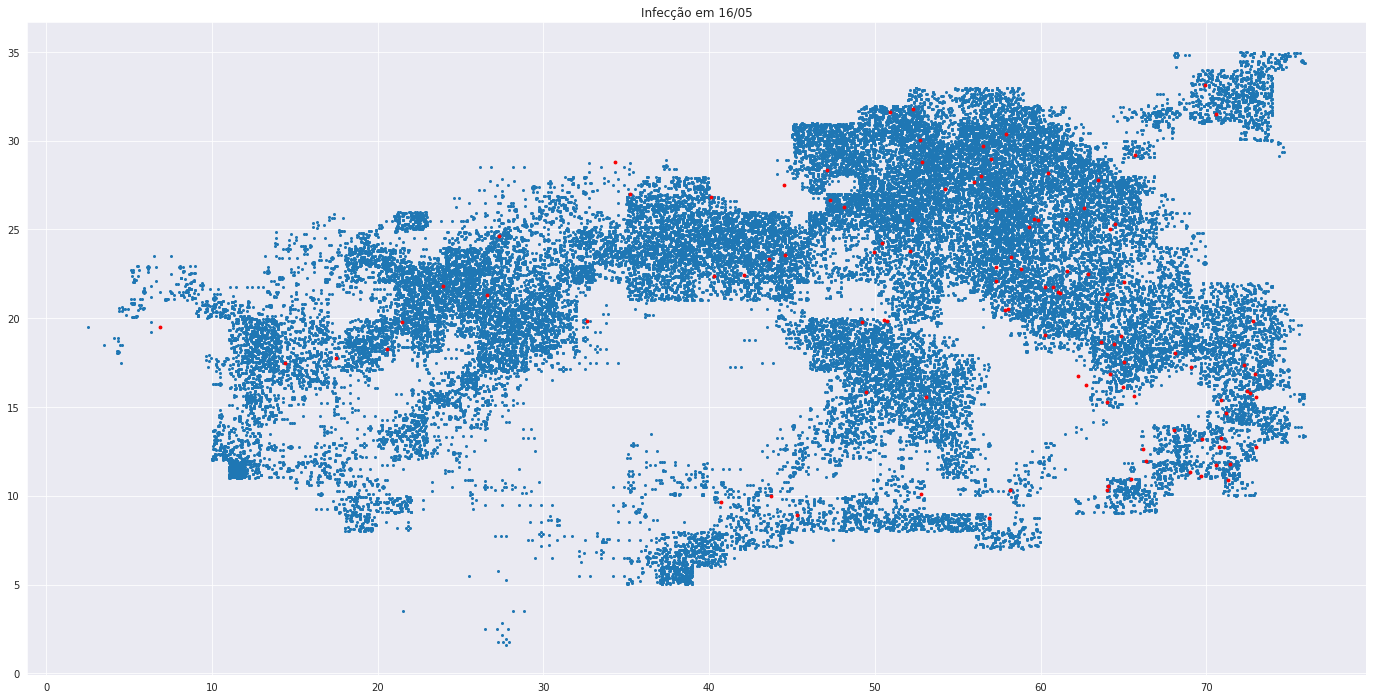

In [70]:
x, y = cenario_rio.pop_posicoes.T
x_inf, y_inf = cenario_rio.pop_posicoes[infectados_1605_0].T
plt.figure(figsize=(24,12))
plt.scatter(x, y, s=4)
plt.scatter(x_inf, y_inf, s=8, color = 'red')
plt.title('Infecção em 16/05')
plt.show()

In [93]:
infectados_0

[61188,
 59709,
 58304,
 62804,
 64408,
 44087,
 32004,
 36944,
 41519,
 32803,
 52651,
 41635,
 67044,
 11432,
 67047,
 67656,
 37865,
 66600,
 37828,
 14960,
 15001,
 14987,
 23616,
 64647,
 66749,
 63784,
 61512,
 29456,
 34181,
 29542,
 8751,
 5897,
 62928,
 6068,
 65650,
 57299,
 52908,
 49403,
 52940,
 29781,
 63842,
 38359,
 50048,
 25024,
 24964,
 29823,
 20502,
 6854,
 66144,
 56019,
 16500,
 63903,
 53626,
 25366,
 21086,
 16895,
 30508,
 21166,
 7684,
 42322,
 42413,
 35415,
 17336,
 46273,
 46523,
 17532,
 30976,
 64033,
 65014,
 64043,
 64008,
 50254,
 50326,
 50442,
 17750,
 2521,
 64096,
 63172,
 50383,
 64150,
 64201,
 63191,
 50555,
 46696,
 42860,
 63208,
 46781,
 63238,
 64258,
 50878,
 50834,
 50867,
 51031,
 46933,
 969,
 198,
 212,
 63403,
 63437,
 63425,
 61971,
 61949,
 59305,
 58090,
 54379,
 2840,
 59479,
 58159,
 58064,
 54343,
 51218,
 62020,
 56592,
 56509,
 56526,
 56559,
 5814]